In [1]:
import tensorflow as tf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
import random
import taglib
import jams
import muda
import time
print(tf.__version__, librosa.__version__)
%matplotlib inline

('1.2.1', '0.5.1')


# Pipeline for Second Hand Songset

In [2]:
TRAIN_FOLDER = "/Users/markostamenovic/code/shs/shs_train"

In [3]:
def txt_to_cliques(shs_loc):
    '''
    reads a textfile of song cliques in shs
    creates a dictionary out of second hand songset 'cliques'
    or groups of cover songs and returns the dict of cliques
    based on their msd id
    '''
    shs = list(open(shs_loc))
    shs = shs[14:]
    cliques = {}
    for ent in shs:
        ent = ent.replace('\n','')
        if ent[0] == '%':
            tempKey = ent.lower()
            cliques[tempKey] = []
        else:
            cliques[tempKey].append(ent.split("<SEP>")[0]+'.mp3')
    return cliques
cliques = txt_to_cliques(os.path.join(TRAIN_FOLDER, "shs_dataset_train.txt"))

In [4]:
def get_labels(cliques):
    # get and flatten all combination of coversongs
    positive_examples = (list(itertools.combinations(val,2)) for key,val in cliques.items())
    positive_examples = [i for j in positive_examples for i in j]
    positive_len_og = len(positive_examples)
    positive_labels = [[0,1] for _ in positive_examples]
    # generate negative examples of an equivalent length to the positive examples list
    song_from_each_clique = (random.choice(val) for key,val in cliques.items())
    negative_examples = itertools.combinations(song_from_each_clique,2)
    negative_examples = list(itertools.islice(negative_examples, positive_len_og))
    negative_labels = [[1,0] for _ in negative_examples]
    # 
    x = positive_examples + negative_examples
    y = positive_labels + negative_labels
    return zip(x,y)

In [5]:
def join_files_to_path(targets_labels):
    return [(map(lambda x: os.path.join(TRAIN_FOLDER, x), target), label) for target,label in targets_labels] 

In [6]:
corrupted_folder = "/Users/markostamenovic/code/shs/shs_train/small_size_mp3s"

def prune_corrupted_files(targets_labels):
    corrupted_folder = os.path.join(TRAIN_FOLDER, "small_size_mp3s")
    pruned = []
    corrupted = [i for i in os.listdir(corrupted_folder) if i.endswith("mp3")]
    clean = [i for i in os.listdir(TRAIN_FOLDER) if i.endswith("mp3")]
    
    for target, label in targets_labels:
        if target[0] in corrupted or target[1] in corrupted:
            pass
        if target[0] not in clean or target[1] not in clean:
            pass
        else:
            pruned.append((target,label))
    return pruned
    

In [93]:
def process_one_file(file_path, _duration, augmentation = True):
#     1 loop, best of 3: 578 ms per loop
#     t0 = time.time()
    file_path = file_path[0]
    stretch_scale = .05
#     duration = np.multiply( _duration, ( np.add( np.multiply( stretch_scale, 2), 1))) # we do this to pad for potential stretch
    f_len = np.float32(taglib.File(file_path).length)
    # require(duration >= f_len) check that duration is below length
    start_bound = np.subtract(f_len, _duration)
    start = np.float(np.random.randint(0,start_bound))
    y, sr = librosa.core.load(path = file_path,
                              offset = start,
                              duration = _duration,  
                              res_type='kaiser_fast')
    ''' deformation pipeline'''
    if augmentation:
        jam = jams.JAMS()
        jam.file_metadata.duration = librosa.get_duration(y=y, sr=sr)
        jam.file_metadata.identifiers = os.path.basename(file_path)
        j_orig = muda.jam_pack(jam, _audio=dict(y=y, sr=sr))
        pitch_shift = muda.deformers.RandomPitchShift(n_samples=1, mean=0.0, sigma=1.0)
        time_stretch = muda.deformers.RandomTimeStretch(n_samples=1, location=0.0, scale=stretch_scale)
    #     noise = muda.deformers.BackgroundNoise(n_samples=1)
    #     drc = muda.deformers.DynamicRangeCompression(preset=muda.deformers.PRESETS.keys())
    #     drc = muda.deformers.PRESETS.keys()
    #     drc.append(False)
    #     drc = random.choice(drc)
    #     if drc:
    #         compress = muda.deformers.DynamicRangeCompression(preset=drc)
    #     else:
    #         compress = time_stretch
        pipeline = muda.Pipeline(steps=[('pitch_shift', pitch_shift),
                                        ('time_stretch', time_stretch)])
        out = list(pipeline.transform(j_orig))[0]
        y_t, sr_t = out.sandbox.muda._audio.values()
        '''zero pad for deformation length change'''
    else:
        y_t = y
        sr_t = sr
        
    required_samples = _duration*sr_t
    deformed_samples = y_t.shape[0]
    sample_diff = np.abs(np.subtract(deformed_samples,required_samples))

    if deformed_samples > required_samples:
        y_t = y_t[:required_samples]
    else:
        y_t = np.lib.pad(y_t, (0,sample_diff), 'constant', constant_values=(0, 0))
    
    '''get cqt'''
    cqt = librosa.core.cqt(y_t, sr=sr_t,
                           hop_length=1024, 
                           fmin=None, n_bins=84, 
                           bins_per_octave=12, 
                           tuning=0.0, 
                           filter_scale=1, 
                           norm=1, 
                           sparsity=0.01, 
                           window='hann', 
                           scale=True)
    
#     elapsed = time.time() - t0
#     print("elapsed = {}").format(elapsed)
    return librosa.power_to_db(np.abs(cqt).astype("float32"),ref=np.max)

In [9]:
targets_labels = join_files_to_path(prune_corrupted_files(get_labels(cliques)))
targets_t_0 = tf.cast(tf.expand_dims(tf.convert_to_tensor(np.array(targets_labels)[:,0][:,0]),1), tf.string)
targets_t_1 = tf.cast(tf.expand_dims(tf.convert_to_tensor(np.array(targets_labels)[:,0][:,1]),1), tf.string)
labels_t = tf.convert_to_tensor(np.array(targets_labels)[:,1].astype("float32"))

In [10]:
f0, f1, labels = tf.train.slice_input_producer(
    [targets_t_0, targets_t_1, labels_t], 
    num_epochs=None, 
    shuffle=True, 
    seed=None, 
    capacity=10000)

In [94]:
def get_slices(filename, sr=22050, hop_length=1024, duration=15, file_read_dur=29):
    frames_pre_sec = int(sr/hop_length)
    slice_size = duration*(frames_pre_sec)
#     print(slice_size)
    spec_1_t = tf.py_func(process_one_file, [filename, file_read_dur], tf.float32)
#     _, ncols = spec_1_t.shape.as_list()
    ncols=625
    spec_1_t.set_shape([84, 625])
    at_win = tf.map_fn(lambda i: spec_1_t[:,i:i+slice_size], tf.range(ncols - slice_size+1), dtype=tf.float32)
    at_shuff = tf.random_shuffle(at_win)
    return at_shuff

In [119]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    a,b = sess.run([specs, labels_tiled])
    print(a.shape, b.shape)
    coord.request_stop()
    coord.join(threads)

((311, 2, 84, 315), (311, 2))


KeyboardInterrupt: 

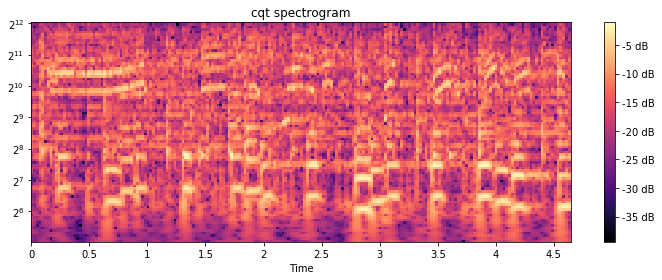

In [121]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(a[1][1][:,:200],
                          y_axis='cqt', fmax=11025,
                          x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('cqt spectrogram')
plt.tight_layout()

In [110]:
specs = tf.stack([get_slices(f0), get_slices(f1)],1)
labels_tiled = tf.tile(tf.expand_dims(labels,0),[tf.shape(specs)[0],1])

In [114]:
example_batch, label_batch = tf.train.shuffle_batch(
    
    [specs, labels_tiled],                            
    batch_size = 16,                       # dequeue this many
    capacity = 8192,                       # this is the queue capacity
    min_after_dequeue = 7192,              # minimum after dq
    num_threads=8,
    enqueue_many = True,                   # push multiple examples to queue for each input producer 
    shapes = [tf.TensorShape([2, 84, 315]),
              tf.TensorShape([2])]# shape of the non-batch dimension

)

In [117]:
example_batch, label_batch = tf.train.shuffle_batch_join(
    
    [[specs, labels_tiled]]*8,                            
    batch_size = 16,                       # dequeue this many
    capacity = 8192,                       # this is the queue capacity
    min_after_dequeue = 7192,              # minimum after dq
    enqueue_many = True,                   # push multiple examples to queue for each input producer 
    shapes = [tf.TensorShape([2, 84, 315]),
              tf.TensorShape([2])]# shape of the non-batch dimension

)

In [118]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    steps_per_sec = []
    for _ in range(100):
        t0 = time.time()
        a,b = sess.run([example_batch, label_batch])
        print(a.shape, b.shape)
        elapsed = time.time() - t0
        steps_sec = 1/elapsed
        print("steps per sec = {}").format(steps_sec)
        steps_per_sec.append(steps_sec)
    print("mean steps per sec = {}").format(np.mean(steps_per_sec[4:])) #drop the first few steps bc thats filling queue
    coord.request_stop()
    coord.join(threads)

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.InvalidArgumentError'>, exceptions.ValueError: low >= high
	 [[Node: PyFunc_5 = PyFunc[Tin=[DT_STRING, DT_INT32], Tout=[DT_FLOAT], token="pyfunc_5", _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer/Gather_1, PyFunc_5/input_1)]]
((16, 2, 84, 315), (16, 2))
steps per sec = 0.0066053569348
((16, 2, 84, 315), (16, 2))
steps per sec = 6.04997720965
((16, 2, 84, 315), (16, 2))
steps per sec = 0.0972415584842
((16, 2, 84, 315), (16, 2))
steps per sec = 2.12568722531
((16, 2, 84, 315), (16, 2))
steps per sec = 0.0916461258971
((16, 2, 84, 315), (16, 2))
steps per sec = 5.98375913763
((16, 2, 84, 315), (16, 2))
steps per sec = 4.91200144281
((16, 2, 84, 315), (16, 2))
steps per sec = 3.16876970894
((16, 2, 84, 315), (16, 2))
steps per sec = 0.0929256966236
((16, 2, 84, 315), (16, 2))
steps per sec = 0.561704995277
((16, 2, 84, 315), (16, 2))
steps per sec = 5.18244619926
((16, 2, 84, 31

InvalidArgumentError: exceptions.ValueError: low >= high
	 [[Node: PyFunc_5 = PyFunc[Tin=[DT_STRING, DT_INT32], Tout=[DT_FLOAT], token="pyfunc_5", _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer/Gather_1, PyFunc_5/input_1)]]